# **Sprint 8**
## 4. Análisis exploratorio de datos (Empresas & Barrios)

Este cuaderno implementa un **Análisis Exploratorio de Datos (AED)** aplicado a dos fuentes clave:

- **Empresas** (`company_name`, `trips_amount`) → viajes realizados por compañía de taxis (15–16 noviembre 2017).  
- **Barrios** (`dropoff_location_name`, `average_trips`) → número promedio de finalizaciones por barrio (noviembre 2017).  

El objetivo es caracterizar la **distribución y concentración** de viajes en ambos niveles (oferta y demanda), detectar posibles **asimetrías** o **outliers**, y evaluar el grado de **competencia o concentración del mercado**.

---

### **Estructura del notebook**
1. **Configuración y parámetros**  
   Establece librerías, estilo gráfico y utilidades comunes para asegurar reproducibilidad y consistencia.
2. **Carga y revisión de datos**  
   Importación segura con validación inicial de dimensiones y columnas.
3. **Limpieza y validación**  
   Tipado correcto, control de nulos, eliminación de valores no plausibles (≤0) y duplicados.
4. **Análisis exploratorio (AED)**  
   Estadísticos descriptivos, interpretación de sesgo/curtosis y variabilidad relativa (CV), con histogramas de apoyo.
5. **Top 10 y visualizaciones**  
   Ranking de empresas y barrios, participaciones de mercado, concentración acumulada y comparativas Top1 vs promedio.
6. **Análisis de concentración (Pareto & métricas)**  
   k(80%), CR4/CR8 y HHI para evaluar poder de mercado y estructura competitiva.
7. **Conclusiones ejecutivas**  
   Síntesis en Markdown con tabla comparativa, interpretación de métricas y recomendaciones prácticas.
8. **Exportación (opcional)**  
   Generación de outputs (tablas, gráficos) para informes o tableros.

---

### **Valor esperado**
- Detectar si el mercado está **atomizado** o **concentrado**.  
- Cuantificar el peso de los **principales actores** (empresas / barrios).  
- Generar **insumos claros y accionables** para decisiones estratégicas (alianzas, cobertura, monitoreo).

## 5.1 Configuración base

### **Objetivo**  
Definir un entorno consistente de trabajo y visualización que asegure **reproducibilidad**, **legibilidad** y **estética homogénea** en todas las figuras y reportes.

### **Qué hace este bloque y por qué**  
- **Imports estándar**: `pandas`, `numpy`, `matplotlib`, `scipy` y utilidades de Jupyter.  
- **Opciones de pandas**: muestra todas las columnas y amplía el ancho para evitar cortes.  
- **Estilo global de matplotlib**: fija tamaño, resolución, tipografías y elimina bordes superiores/derechos, garantizando uniformidad en gráficos.  
- **Utilidades de formateo**:  
  - `fmt_miles_inter`: formatea ticks con separador de miles y punto decimal (internacional).  
  - `fmt_pct`: convierte valores 0–1 en porcentajes (0–100%).  
  - `str_miles_inter`: genera strings formateados para anotaciones y etiquetas en gráficas.  
- **Paleta de colores**: diccionario `COLORS` con códigos hex para mantener consistencia visual entre secciones.

### **Resultados esperados**  
- Un entorno gráfico **estandarizado** y profesional.  
- Evita duplicar lambdas o strings de formateo en cada gráfica.  
- Mejora la **claridad visual** y la **interpretabilidad** de los resultados.

In [2]:
# --- Cargar librerías ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display
from matplotlib.ticker import FuncFormatter

# --- Opciones de pandas (legibilidad en Jupyter) ---
pd.set_option('display.max_columns', None)   # mostrar todas las columnas
pd.set_option('display.width', 1000)         # aumentar ancho para evitar cortes

# --- Estilo global de matplotlib (asegura coherencia en TODAS las figuras) ---
plt.rcParams.update({
    "figure.figsize": (11, 5.5),   # tamaño estándar de figuras
    "figure.dpi": 120,             # resolución moderada (presentación + exportación)
    "axes.grid": True,             # grilla activa por defecto
    "grid.alpha": 0.6,
    "grid.linewidth": 0.5,
    "axes.spines.top": False,      # elimina borde superior
    "axes.spines.right": False,    # elimina borde derecho
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# --- Formateadores y utilidades reutilizables ---
def fmt_miles_inter(x, pos=None):
    """
    Formatea ticks de ejes con estilo internacional:
    - Miles con coma, decimales con punto.
    - Usa decimales si |x| < 1000, si no entero redondeado.
    """
    if abs(x) < 1000:
        s = f"{x:,.1f}"       # un decimal para valores pequeños
    else:
        s = f"{int(round(x)):,}"  # enteros para valores grandes
    return s

def fmt_pct(y, pos=None):
    """
    Formatea ticks en porcentaje (0–100%).
    Ej: 0.25 -> '25%'.
    """
    return f"{y*100:.0f}%"

def str_miles_inter(x, dec=1):
    """
    Convierte valores numéricos a string (para anotaciones en barras/texto).
    - Miles con coma, decimales con punto.
    - Si |x| < 1000, usa 'dec' decimales; si no, entero redondeado.
    """
    if isinstance(x, float) and abs(x) < 1000:
        s = f"{x:.{dec}f}"
    else:
        s = f"{int(round(x)):,}"
    return s

# --- Paleta de colores consistente (útil en comparaciones y dashboards) ---
COLORS = {"empresas": "#3d9ab3", "barrios": "#e0af01"}

## 2. Carga de datos

### **Objetivo**  
Ingerir las fuentes de datos (empresas y barrios) y verificar rápidamente su estructura antes del análisis.

### **Qué hace este bloque y por qué**  
- **Lectura de CSVs**: `pd.read_csv` se aplica a las dos tablas clave del análisis (`empresas` y `barrios`).  
- **Control de errores**: uso de `try/except` para capturar problemas comunes (archivos no encontrados, formatos corruptos, permisos).  
- **Validación inicial**: impresión de dimensiones de cada dataset y despliegue de las primeras filas (`head()`), confirmando que las columnas esperadas están presentes y que la carga fue correcta.

### **Supuestos y alcance**  
- Archivos localizados en `../data/` y con formato CSV legible por `pandas`.  
- Columnas deben ser consistentes con el análisis posterior (ej. identificadores, métricas clave por empresa y barrio).

### **Resultados esperados**  
- `df_empresas` y `df_barrios` cargados como DataFrames de `pandas`.  
- Validación rápida de filas y columnas antes de pasar a limpieza y transformación.  
- Mensajes claros de éxito o error para asegurar trazabilidad en la ejecución.

In [3]:
# ---Carga de datos: empresas y barrios ---

try:
    # Lectura de archivos CSV (se asume ruta relativa ../data/)
    df_empresas = pd.read_csv("../data/project_sql_result_01.csv")  # Datos de empresas
    df_barrios  = pd.read_csv("../data/project_sql_result_04.csv")  # Datos de barrios

    # Reporte inicial de éxito + dimensiones
    print("Datos cargados correctamente.")
    print("Dimensiones: empresas:", df_empresas.shape,
          " | barrios:", df_barrios.shape)

    # Vista preliminar de los primeros registros
    display(df_empresas.head())
    display(df_barrios.head())

except Exception as e:
    # Captura robusta de errores: rutas inválidas, permisos, formato, etc.
    print("Error al cargar los datos:", e)

Datos cargados correctamente.
Dimensiones: empresas: (64, 2)  | barrios: (94, 2)


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


## 3. Validación, tipado y limpieza

### **Objetivo**  
Asegurar que los datasets (`empresas` y `barrios`) estén **consistentes, tipados correctamente y libres de errores comunes** antes del análisis.

### **Qué hace este bloque y por qué**  
- **Tipado y limpieza de strings**: estandariza `company_name` y `dropoff_location_name` como texto limpio, y convierte métricas a numéricas.  
- **Control de nulos**: detecta y elimina registros sin valores en columnas clave.  
- **Filtros de plausibilidad**: elimina valores de viajes ≤ 0, que no tienen sentido práctico.  
- **Duplicados**: identifica claves repetidas y conserva solo la primera ocurrencia, evitando distorsiones en agregaciones.  
- **Redondeo**: aplica redondeo para presentación, sin afectar cálculos de conteo o proporciones.  
- **Reporte final**: muestra nulos, filas removidas, duplicados y rangos de valores, garantizando transparencia en el pipeline.

### **Supuestos y alcance**  
- Los archivos contienen al menos las columnas mínimas:  
  - Empresas: `company_name`, `trips_amount`.  
  - Barrios: `dropoff_location_name`, `average_trips`.  
- Los valores negativos o cero son considerados inválidos en el contexto de viajes.

### **Resultados esperados**  
- `emp_ok` y `bar_ok`: DataFrames limpios, tipados y listos para análisis.  
- Documentación clara de las transformaciones aplicadas y registros descartados.

In [4]:
# --- Validación, tipado y limpieza de datos ---
def validar_tipar_limpiar(df_emp, df_bar, round_dec=2):
    """
    Aplica un pipeline de validación, tipado y limpieza a los DataFrames de
    empresas y barrios.

    Pasos:
    1. Validación de entrada (asegurar DataFrames no nulos).
    2. Tipado consistente:
       - 'company_name', 'dropoff_location_name' → string sin espacios extra.
       - 'trips_amount', 'average_trips' → numéricos (coerción de errores).
    3. Reporte y remoción de nulos en columnas clave.
    4. Eliminación de valores ≤ 0 (no plausibles).
    5. Detección y eliminación de duplicados (manteniendo la primera ocurrencia).
    6. Redondeo de métricas (para presentación, no afecta cálculos posteriores).
    7. Reporte de registros removidos y rangos finales.

    Parámetros
    ----------
    df_emp : pd.DataFrame
        Dataset de empresas con columnas ['company_name','trips_amount'].
    df_bar : pd.DataFrame
        Dataset de barrios con columnas ['dropoff_location_name','average_trips'].
    round_dec : int
        Número de decimales para redondear valores (presentación).

    Retorna
    -------
    emp, bar : tuple[pd.DataFrame, pd.DataFrame]
        DataFrames limpios y reindexados.
    """
    if df_emp is None or df_bar is None:
        raise RuntimeError("No hay dataframes para validar.")

    # Copia de seguridad
    emp = df_emp.copy()
    bar = df_bar.copy()

    # Tipado y limpieza de strings
    emp['company_name'] = emp['company_name'].astype('string').str.strip()
    bar['dropoff_location_name'] = bar['dropoff_location_name'].astype('string').str.strip()
    emp['trips_amount'] = pd.to_numeric(emp.get('trips_amount'), errors='coerce')
    bar['average_trips'] = pd.to_numeric(bar.get('average_trips'), errors='coerce')

    # Reporte de nulos
    print("Nulos — EMPRESAS:\n", emp.isna().sum())
    print("\nNulos — BARRIOS:\n", bar.isna().sum())

    # Remover nulos en columnas clave
    emp = emp.dropna(subset=['company_name','trips_amount'])
    bar = bar.dropna(subset=['dropoff_location_name','average_trips'])

    # Filtrado de valores no plausibles (≤0)
    neg_emp = (emp['trips_amount'] <= 0).sum()
    neg_bar = (bar['average_trips'] <= 0).sum()
    emp = emp[emp['trips_amount'] > 0]
    bar = bar[bar['average_trips'] > 0]

    # Duplicados por clave (mantener primer registro)
    dupe_emp = emp.duplicated(['company_name']).sum()
    dupe_bar = bar.duplicated(['dropoff_location_name']).sum()
    if dupe_emp:
        print(f"Duplicados por company_name: {dupe_emp} (se conserva el primero)")
        emp = emp[~emp.duplicated(['company_name'], keep='first')]
    if dupe_bar:
        print(f"Duplicados por dropoff_location_name: {dupe_bar} (se conserva el primero)")
        bar = bar[~bar.duplicated(['dropoff_location_name'], keep='first')]

    # Redondeo para presentación
    emp['trips_amount'] = emp['trips_amount'].round(round_dec)
    bar['average_trips'] = bar['average_trips'].round(round_dec)

    # Reporte final
    print(f"\nFilas removidas EMP (≤0): {neg_emp}")
    print(f"Filas removidas BAR (≤0): {neg_bar}")
    print(f"\nEMPRESAS — rango de viajes: {emp['trips_amount'].min()} — {emp['trips_amount'].max()}")
    print(f"BARRIOS  — rango de viajes promedio: {bar['average_trips'].min()} — {bar['average_trips'].max()}")

    return emp.reset_index(drop=True), bar.reset_index(drop=True)


# Ejecución del pipeline de limpieza
try:
    emp_ok, bar_ok = validar_tipar_limpiar(df_empresas, df_barrios, round_dec=2)
except Exception as e:
    print("⚠️ Error en validación/limpieza:", e)
    emp_ok, bar_ok = None, None

Nulos — EMPRESAS:
 company_name    0
trips_amount    0
dtype: int64

Nulos — BARRIOS:
 dropoff_location_name    0
average_trips            0
dtype: int64

Filas removidas EMP (≤0): 0
Filas removidas BAR (≤0): 0

EMPRESAS — rango de viajes: 2 — 19558
BARRIOS  — rango de viajes promedio: 1.8 — 10727.47


## 4. EDA: forma de la distribución y variabilidad

### **Objetivo**
Caracterizar la distribución de **viajes por empresa** y **viajes promedio por barrio** para detectar asimetrías, colas y variabilidad relativa antes de modelos o pruebas.

### **Qué hace este bloque y por qué**
- **Descriptivos clave**: `describe()` para tamaño, media, dispersión y cuantiles.
- **Forma de la distribución**: interpreta **sesgo** (asimetría) y **curtosis** (colas) con umbrales suaves (±0.1) para evitar sobre-interpretaciones.
- **Variabilidad relativa**: **CV** (DE/media) en %, útil para comparar escalas distintas.
- **Histogramas**: lectura visual consistente con formateo de miles.

### **Guía de lectura**
- **Sesgo**: positivo ⇒ cola a la derecha; negativo ⇒ cola a la izquierda; ~0 ⇒ simétrica.
- **Curtosis**: >0 ⇒ colas pesadas (leptocúrtica); <0 ⇒ colas ligeras (platicúrtica); ≈0 ⇒ normal (mesocúrtica).
- **CV**: mayor CV ⇒ mayor heterogeneidad relativa (cuidado con outliers).

### **Resultados esperados**
- Resumen numérico y visual de ambas variables.
- Insumos para decidir transformaciones (p. ej., log) o robustecer pruebas si hay asimetrías/colas marcadas.

=== ESTADÍSTICAS BÁSICAS ===

EMPRESAS:
              count     mean      std  min    25%    50%     75%      max
trips_amount   64.0  2145.48  3812.31  2.0  20.75  178.5  2106.5  19558.0:

BARRIOS:
               count    mean      std  min    25%    50%     75%       max
average_trips   94.0  599.95  1714.59  1.8  14.26  52.02  298.85  10727.47:

=== ESTADÍSTICAS DE DISTRIBUCIÓN ===

EMPRESAS:
  Sesgo: 2.40 → asimetría positiva (cola a la derecha)
  Curtosis: 6.52 → leptocúrtica (colas pesadas, más valores extremos que normal)
  Coeficiente de variación (CV): 177.69%

BARRIOS:
  Sesgo: 4.52 → asimetría positiva (cola a la derecha)
  Curtosis: 21.70 → leptocúrtica (colas pesadas, más valores extremos que normal)
  Coeficiente de variación (CV): 285.79%


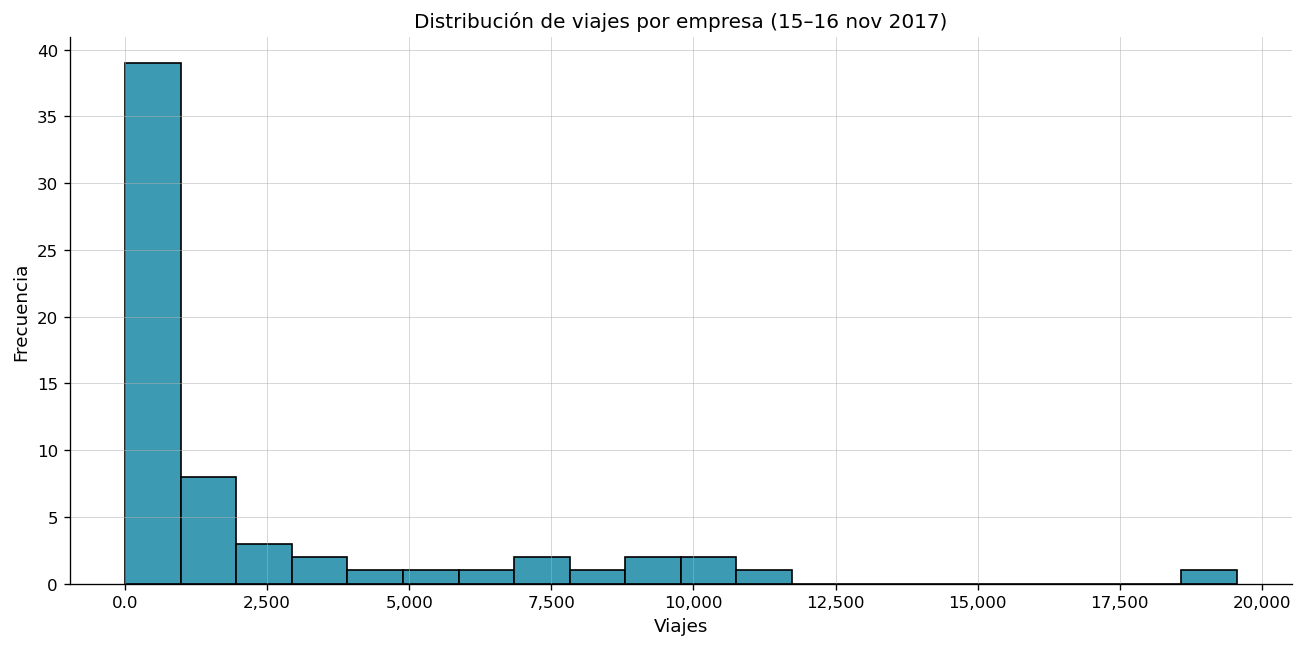

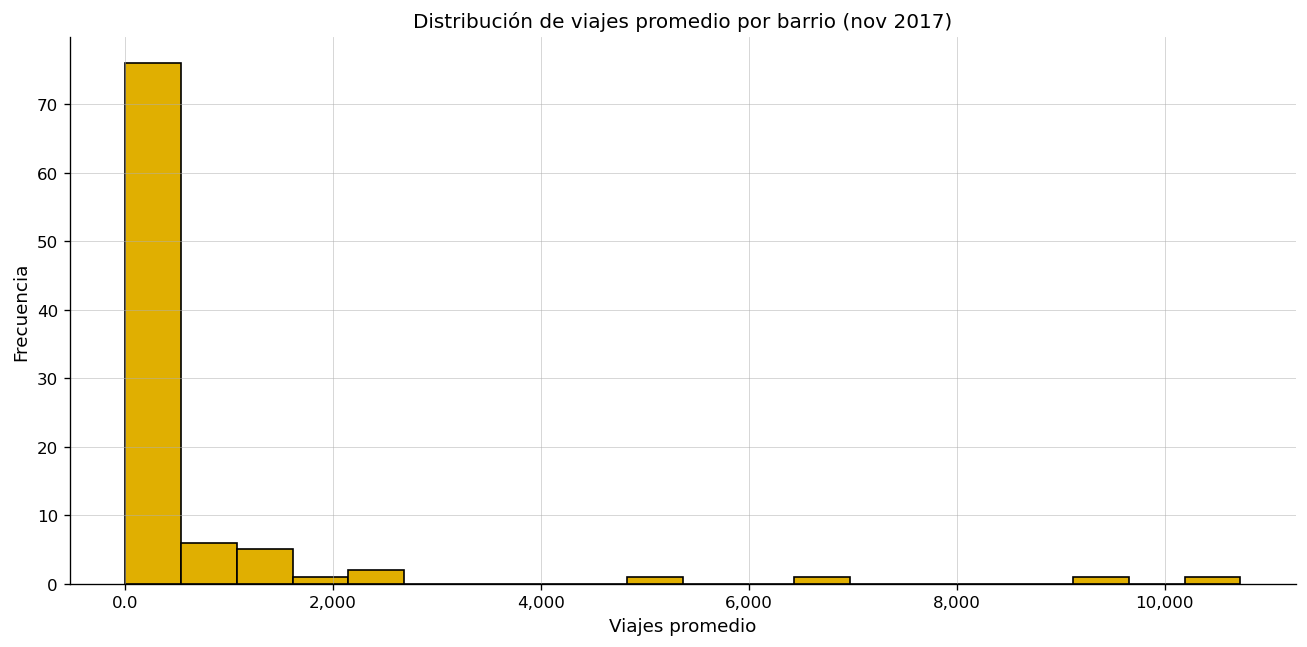

In [5]:
# --- Función de interpretación de sesgo y curtosis ---
def skew_kurt(skew: float, kurt: float) -> tuple[str, str]:
    """
    Interpreta el sesgo (asimetría) y la curtosis de una distribución.

    Parámetros
    ----------
    skew : float
        Sesgo de la distribución (positivo = cola a la derecha).
    kurt : float
        Exceso de curtosis (0 ≈ normal). Valores >0 implican colas más pesadas.

    Retorna
    -------
    (skew_txt, kurt_txt) : tuple[str, str]
        Descripciones textuales de sesgo y curtosis.
    """
    # Umbrales suaves ±0.1 para no sobre-interpretar ruido
    if skew > 0.1:
        skew_txt = "asimetría positiva (cola a la derecha)"
    elif skew < -0.1:
        skew_txt = "asimetría negativa (cola a la izquierda)"
    else:
        skew_txt = "distribución aproximadamente simétrica"

    if kurt > 0.1:
        kurt_txt = "leptocúrtica (colas pesadas, más valores extremos que normal)"
    elif kurt < -0.1:
        kurt_txt = "platicúrtica (colas ligeras, menos valores extremos que normal)"
    else:
        kurt_txt = "mesocúrtica (similar a normal)"

    return skew_txt, kurt_txt


# --- Histograma estandarizado ---
def draw_hist(values: np.ndarray, title: str, xlabel: str, color: str, bins: int | None = None) -> None:
    """
    Dibuja un histograma con formato consistente.

    - Usa formateo internacional en eje X si está disponible.
    - Permite fijar bins; si no se pasan, usa 20 (coherente con tu versión original).

    Parámetros
    ----------
    values : array-like
        Serie numérica a graficar.
    title : str
        Título de la figura.
    xlabel : str
        Etiqueta del eje X.
    color : str
        Color de barras.
    bins : int | None
        Número de bins; si None, usa 20.
    """
    values = np.asarray(values, float)
    plt.figure()
    plt.hist(values, bins=(bins or 20), color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    ax = plt.gca()
    # Formateador de miles si existe en el entorno
    try:
        ax.xaxis.set_major_formatter(FuncFormatter(fmt_miles_inter))
    except Exception:
        pass
    plt.tight_layout()
    plt.show()


# --- EDA básico para empresas y barrios ---
def eda(emp_ok: pd.DataFrame, bar_ok: pd.DataFrame, show_fig: bool = True) -> dict:
    """
    Realiza un EDA compacto sobre:
      - EMPRESAS: 'trips_amount'
      - BARRIOS : 'average_trips'

    Reporta:
      - Descriptivos (count, mean, std, min, quartiles, max)
      - Sesgo, curtosis e índice de variación (CV)
      - Histogramas (opcional)

    Parámetros
    ----------
    emp_ok : pd.DataFrame
        DataFrame limpio de empresas con columnas ['company_name','trips_amount'].
    bar_ok : pd.DataFrame
        DataFrame limpio de barrios con columnas ['dropoff_location_name','average_trips'].
    show_fig : bool
        Si True, grafica histogramas.

    Retorna
    -------
    dict
        Resumen con métricas clave por dataset.
    """
    if emp_ok is None or bar_ok is None:
        raise RuntimeError("No hay datos para EDA.")

    # --- Estadísticos básicos (redondeados para display) ---
    print("=== ESTADÍSTICAS BÁSICAS ===\n")
    emp_desc = emp_ok['trips_amount'].describe().round(2).to_frame()
    bar_desc = bar_ok['average_trips'].describe().round(2).to_frame()
    print("EMPRESAS:"); print(emp_desc.T, ":", sep="")
    print("\nBARRIOS:"); print(bar_desc.T, ":", sep="")

    # --- Forma de la distribución + CV ---
    print("\n=== ESTADÍSTICAS DE DISTRIBUCIÓN ===")
    resumen = {}
    for df, col, nombre in [
        (emp_ok, 'trips_amount', 'EMPRESAS'),
        (bar_ok, 'average_trips', 'BARRIOS'),
    ]:
        serie = pd.to_numeric(df[col], errors='coerce').dropna()
        skew = float(serie.skew())
        kurt = float(serie.kurtosis())
        skew_r, kurt_r = round(skew, 2), round(kurt, 2)
        skew_txt, kurt_txt = skew_kurt(skew, kurt)
        cv = float(serie.std(ddof=1) / serie.mean() * 100) if serie.mean() != 0 else np.nan

        print(f"\n{nombre}:")
        print(f"  Sesgo: {skew_r:.2f} → {skew_txt}")
        print(f"  Curtosis: {kurt_r:.2f} → {kurt_txt}")
        print(f"  Coeficiente de variación (CV): {cv:.2f}%")

        resumen[nombre] = {
            "count": int(serie.size),
            "mean": float(serie.mean()),
            "std": float(serie.std(ddof=1)),
            "min": float(serie.min()),
            "q1": float(serie.quantile(0.25)),
            "median": float(serie.median()),
            "q3": float(serie.quantile(0.75)),
            "max": float(serie.max()),
            "skew": skew,
            "kurtosis": kurt,
            "cv_pct": cv,
        }

    # Visuales
    if show_fig:
        draw_hist(
            emp_ok['trips_amount'].values,
            "Distribución de viajes por empresa (15–16 nov 2017)",
            "Viajes",
            COLORS.get("empresas", "#3d9ab3"),
        )
        draw_hist(
            bar_ok['average_trips'].values,
            "Distribución de viajes promedio por barrio (nov 2017)",
            "Viajes promedio",
            COLORS.get("barrios", "#e0af01"),
        )

    return resumen


# --- Indicar ejecución de EDA ---
try:
    resumen_eda = eda(emp_ok, bar_ok, show_fig=True)
except Exception as e:
    print("⚠️ EDA no ejecutada:", e)


## 5. Top 10: concentración y posicionamiento

### **Objetivo**
Identificar a los **principales actores** (empresas y barrios) y cuantificar la **concentración** del mercado para priorizar acciones y comunicación.

### **Qué hace este bloque y por qué**
- **Top 10** de empresas por número de viajes (`trips_amount`) y de barrios por finalizaciones promedio (`average_trips`).
- **Participación (%)** por ítem y **concentración acumulada** (Top10/Top5/Top1), útil para evaluar poder de mercado y dependencia de pocos actores.
- **Comparativa Top1 vs Promedio**: expresa la magnitud relativa (× veces el promedio).
- **Barras horizontales anotadas**: lectura rápida con valores al final de cada barra; eje X formateado en miles.

### **Supuestos y alcance**
- Métricas no negativas; si los totales/promedios son 0, se evita la división y se informa.
- Los listados usan las columnas normalizadas en la limpieza:  
  - Empresas: `company_name`, `trips_amount`.  
  - Barrios: `dropoff_location_name`, `average_trips`.

### **Resultados esperados**
- Visibilidad clara de **quién concentra** viajes/finalizaciones.
- Insumos para **priorización operativa/comercial** (p. ej., alianzas con top empresas, focalización en barrios líderes).



TOP 10 EMPRESAS DE TAXIS:
-------------------------------------------------------------------
   1. Flash Cab                           -->   19,558 viajes (14.2% )
   2. Taxi Affiliation Services           -->   11,422 viajes ( 8.3% )
   3. Medallion Leasin                    -->   10,367 viajes ( 7.6% )
   4. Yellow Cab                          -->    9,888 viajes ( 7.2% )
   5. Taxi Affiliation Service Yellow     -->    9,299 viajes ( 6.8% )
   6. Chicago Carriage Cab Corp           -->    9,181 viajes ( 6.7% )
   7. City Service                        -->    8,448 viajes ( 6.2% )
   8. Sun Taxi                            -->    7,701 viajes ( 5.6% )
   9. Star North Management LLC           -->    7,455 viajes ( 5.4% )
  10. Blue Ribbon Taxi Association Inc.   -->    5,953 viajes ( 4.3% )

CONCENTRACIÓN EMPRESAS:
   • Top 10 concentran: 72.3% del mercado
   • Top 5 concentran:  44.1%
   • Top 1 concentra:   14.2%

TOP 10 BARRIOS POR FINALIZACIONES PROMEDIO:
-----------------------

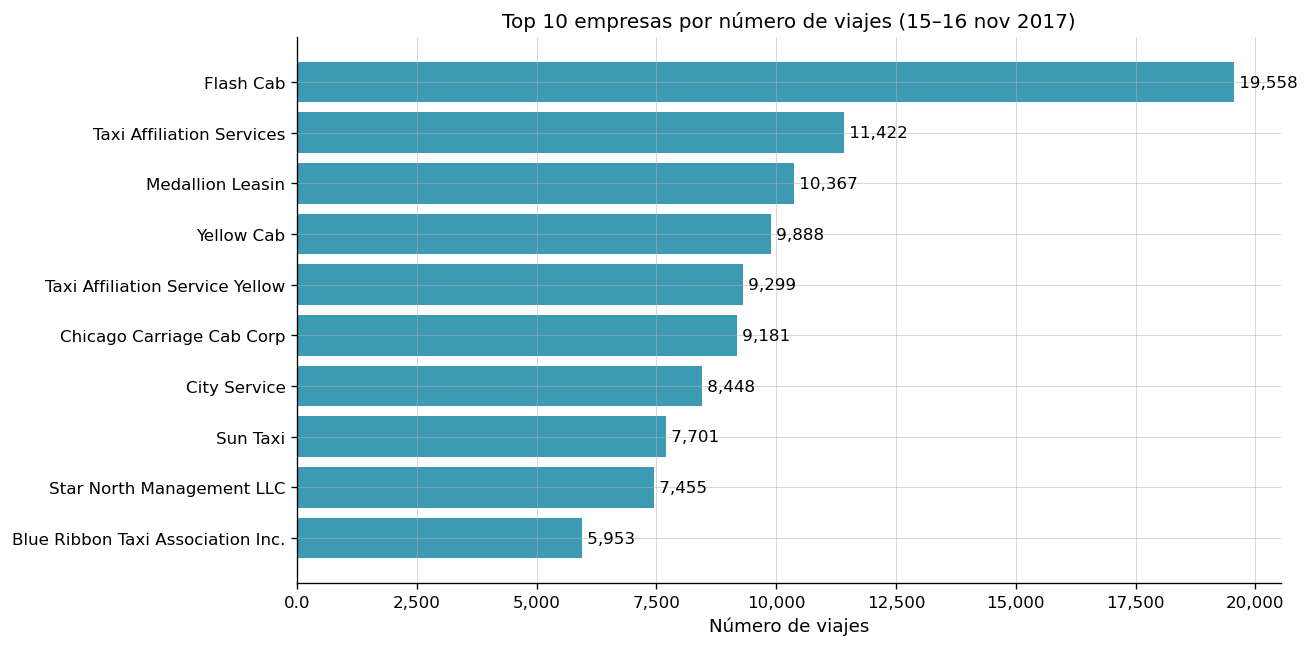

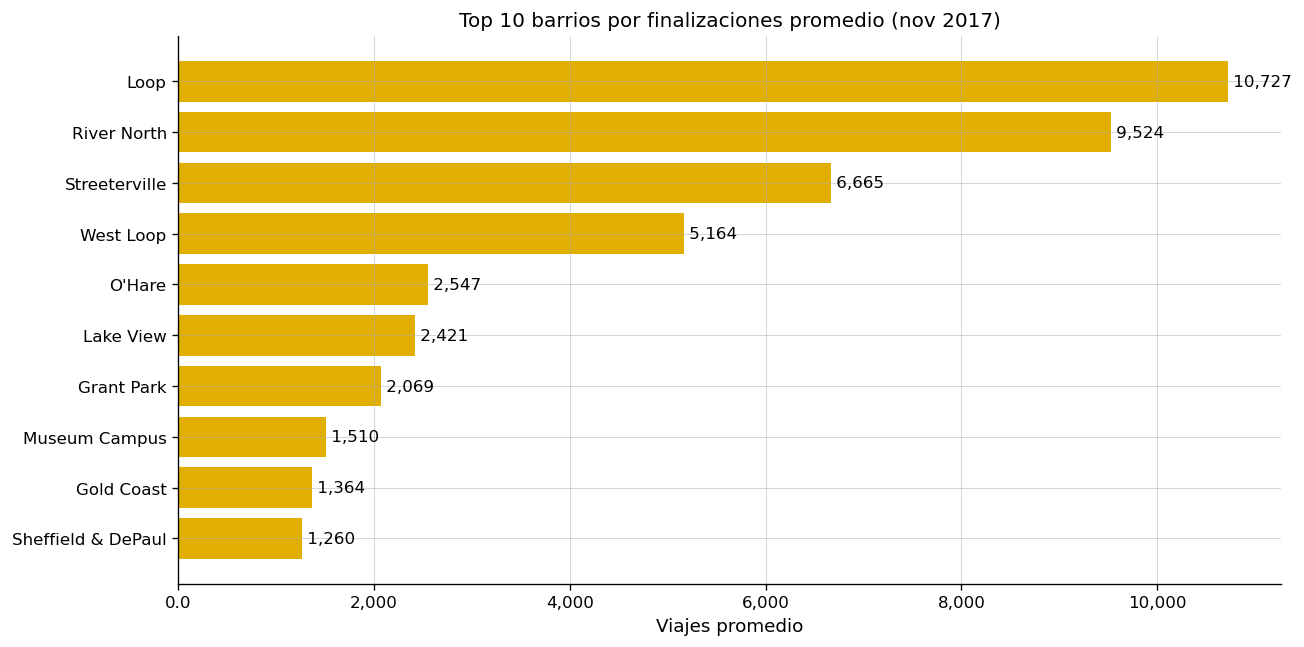

In [6]:
# --- Barras horizontales con anotaciones ---
def barh_annotated(labels,
                   values,
                   title: str,
                   xlabel: str,
                   color: str,
                   dec_label: int = 0) -> None:
    """
    Dibuja un gráfico de barras horizontales (Top-N) con anotaciones numéricas al final.

    Parámetros
    ----------
    labels : array-like
        Etiquetas de cada barra (ya ordenadas si se desea).
    values : array-like
        Valores numéricos correspondientes.
    title : str
        Título de la figura.
    xlabel : str
        Etiqueta del eje X.
    color : str
        Color de las barras.
    dec_label : int
        Decimales en la anotación de valores (0 para conteos, 1+ para promedios).
    """
    import numpy as np
    from matplotlib.ticker import FuncFormatter

    labels = np.asarray(labels)
    values = np.asarray(values, dtype=float)

    if values.size == 0:
        print("Sin datos para graficar.")
        return

    y = np.arange(len(values))
    fig, ax = plt.subplots()
    ax.barh(y, values, color=color)
    ax.set_yticks(y, labels)

    # Formateador de eje X: miles internacionales
    try:
        ax.xaxis.set_major_formatter(FuncFormatter(fmt_miles_inter))
    except Exception:
        pass

    # Anotar valores al final de cada barra
    for i, v in enumerate(values):
        ax.text(v, i, f" {str_miles_inter(v, dec=dec_label)}", va="center")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("")
    ax.grid(True, axis="x")
    fig.tight_layout()

    # Clave: invertir eje Y para que el mayor quede arriba
    ax.invert_yaxis()
    plt.show()


# --- Top 10 y gráficas ---
def top10_y_graficas(emp_ok: pd.DataFrame,
                     bar_ok: pd.DataFrame,
                     show_fig: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calcula y muestra los Top 10 de empresas (por 'trips_amount') y
    de barrios (por 'average_trips'), imprime participación y concentra
    métricas de concentración (Top10/Top5/Top1), y genera barras horizontales.

    Parámetros
    ----------
    emp_ok : pd.DataFrame
        DataFrame de empresas con ['company_name', 'trips_amount'].
    bar_ok : pd.DataFrame
        DataFrame de barrios con ['dropoff_location_name', 'average_trips'].
    show_fig : bool
        Si True, renderiza las barras horizontales anotadas.

    Retorna
    -------
    (top_emp, top_bar) : tuple[pd.DataFrame, pd.DataFrame]
        DataFrames con el Top 10 para empresas y barrios.
    """
    if emp_ok is None or bar_ok is None:
        raise RuntimeError("No hay datos para Top10.")

    # Top 10 (copias ordenadas)
    top_emp = emp_ok.nlargest(10, 'trips_amount').copy()
    top_bar = bar_ok.nlargest(10, 'average_trips').copy()

    # Totales para shares (con manejo robusto de sumas = 0)
    total_viajes_emp = float(emp_ok['trips_amount'].sum(skipna=True))
    total_avg_bar    = float(bar_ok['average_trips'].sum(skipna=True))

    # === Listados con porcentajes (con protección por total = 0) ==============
    print(f"\nTOP 10 EMPRESAS DE TAXIS:")
    print("-" * 67)
    for i, (_, row) in enumerate(top_emp.iterrows(), 1):
        trips = float(row['trips_amount'])
        share = (trips / total_viajes_emp * 100.0) if total_viajes_emp > 0 else np.nan
        print(f"{i:4d}. {str(row['company_name'])[:35]:<35} --> "
              f"{str_miles_inter(trips, dec=0):>8} viajes "
              f"({'' if np.isnan(share) else f'{share:4.1f}%'} )")

    # Concentración de mercado
    s_top10 = float(top_emp['trips_amount'].sum())
    s_top5  = float(top_emp.head(5)['trips_amount'].sum())
    top1    = float(top_emp.iloc[0]['trips_amount']) if len(top_emp) else np.nan
    print(f"\nCONCENTRACIÓN EMPRESAS:")
    if total_viajes_emp > 0:
        print(f"   • Top 10 concentran: {s_top10/total_viajes_emp*100:.1f}% del mercado")
        print(f"   • Top 5 concentran:  {s_top5/total_viajes_emp*100:.1f}%")
        print(f"   • Top 1 concentra:   {top1/total_viajes_emp*100:.1f}%")
    else:
        print("   • Totales = 0: no es posible calcular porcentajes.")

    # Posicionamiento de barrios
    print(f"\nTOP 10 BARRIOS POR FINALIZACIONES PROMEDIO:")
    print("-" * 69)
    for i, (_, row) in enumerate(top_bar.iterrows(), 1):
        avgv = float(row['average_trips'])
        share = (avgv / total_avg_bar * 100.0) if total_avg_bar > 0 else np.nan
        print(f"{i:2d}. {str(row['dropoff_location_name'])[:35]:<35} --> "
              f"{str_miles_inter(avgv, dec=1):>8} viajes/día "
              f"({'' if np.isnan(share) else f'{share:5.1f}%'} )")

    # Concentración de finalizaciones promedio
    s_top10_b = float(top_bar['average_trips'].sum())
    s_top5_b  = float(top_bar.head(5)['average_trips'].sum())
    top1_b    = float(top_bar.iloc[0]['average_trips']) if len(top_bar) else np.nan
    print(f"\nCONCENTRACIÓN BARRIOS:")
    if total_avg_bar > 0:
        print(f"   • Top 10 concentran: {s_top10_b/total_avg_bar*100:.1f}% de finalizaciones")
        print(f"   • Top 5 concentran:  {s_top5_b/total_avg_bar*100:.1f}%")
        print(f"   • Top 1 concentra:   {top1_b/total_avg_bar*100:.1f}%")
    else:
        print("   • Totales = 0: no es posible calcular porcentajes.")

    # Comparativa Top 1 vs promedio (protege promedio = 0)
    avg_emp = float(emp_ok['trips_amount'].mean(skipna=True))
    avg_bar = float(bar_ok['average_trips'].mean(skipna=True))
    print(f"\nCOMPARATIVA TOP 1 vs PROMEDIO:")
    if avg_emp > 0 and not np.isnan(top1):
        print(f"   • Empresa top 1: {top1/avg_emp:.1f}x el promedio")
    else:
        print("   • Empresa top 1: n/d (promedio=0 o sin datos)")
    if avg_bar > 0 and not np.isnan(top1_b):
        print(f"   • Barrio top 1:  {top1_b/avg_bar:.1f}x el promedio")
    else:
        print("   • Barrio top 1: n/d (promedio=0 o sin datos)")

    # --- Gráficas ---
    if show_fig:
        barh_annotated(
            top_emp['company_name'].values,
            top_emp['trips_amount'].values,
            "Top 10 empresas por número de viajes (15–16 nov 2017)",
            "Número de viajes",
            COLORS.get("empresas", "#3d9ab3"),
            dec_label=0,
        )
        barh_annotated(
            top_bar['dropoff_location_name'].values,
            top_bar['average_trips'].values,
            "Top 10 barrios por finalizaciones promedio (nov 2017)",
            "Viajes promedio",
            COLORS.get("barrios", "#e0af01"),
            dec_label=1,
        )

    return top_emp.reset_index(drop=True), top_bar.reset_index(drop=True)


# --- Indicar ejecución de Top10 y gráficas ---
try:
    top_empresas, top_barrios = top10_y_graficas(emp_ok, bar_ok, show_fig=True)
except Exception as e:
    print("⚠️ Top10/Gráficas no ejecutado:", e)
    top_empresas, top_barrios = None, None

## 6. Análisis de concentración: Pareto y métricas complementarias

### **Objetivo**
Evaluar la **concentración del mercado** mediante la regla de Pareto (80/20) y métricas estándar de competencia (HHI, CR4, CR8), tanto para **empresas de taxi** como para **barrios de destino**.

### **Qué hace este bloque y por qué**
- **Curva de Pareto**: ordena unidades de mayor a menor aporte y traza la participación acumulada.  
- **k80**: número mínimo de unidades necesarias para alcanzar el 80% de participación (medida intuitiva de concentración).  
- **HHI (Herfindahl–Hirschman Index)**: suma de cuadrados de participaciones (0–1); valores altos ⇒ concentración elevada.  
- **CR4 y CR8**: participación acumulada de las 4 y 8 principales unidades, indicadores clásicos de poder de mercado.  
- **Visualización**: curva con líneas de referencia al 80% y al punto k80, con ejes formateados.

### **Supuestos y alcance**
- `col_val` debe ser numérico positivo (ej. `trips_amount`, `average_trips`).  
- Total de valores > 0; en caso contrario, se aborta con error.  
- La métrica es relativa: interpreta participación, no volúmenes absolutos.

### **Resultados esperados**
- **Empresas**: número de compañías que concentran el 80% de viajes y su nivel de concentración (HHI, CR4, CR8).  
- **Barrios**: número de barrios que concentran el 80% de finalizaciones promedio y su concentración relativa.  
- Gráficos de Pareto claros, con referencias al 80% y al k80, que permiten leer la estructura competitiva de un vistazo.


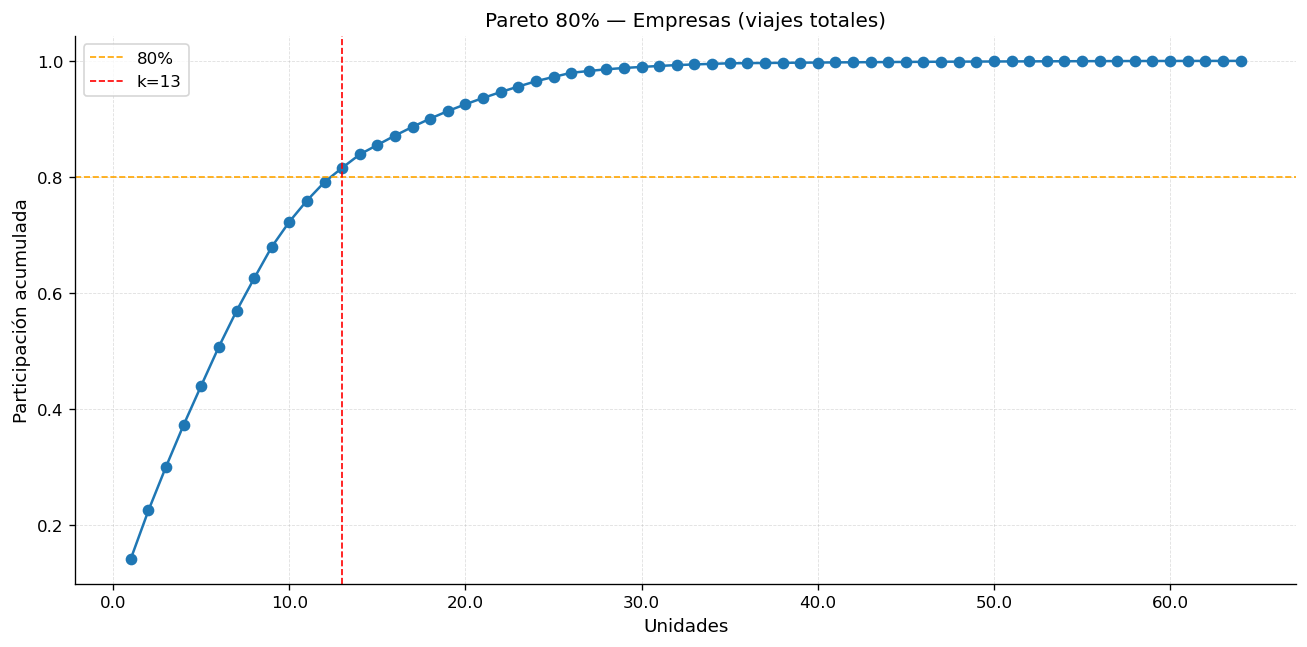

Pareto 80% — Empresas (viajes totales) → k80=13, HHI=0.0642, CR4=0.373, CR8=0.625


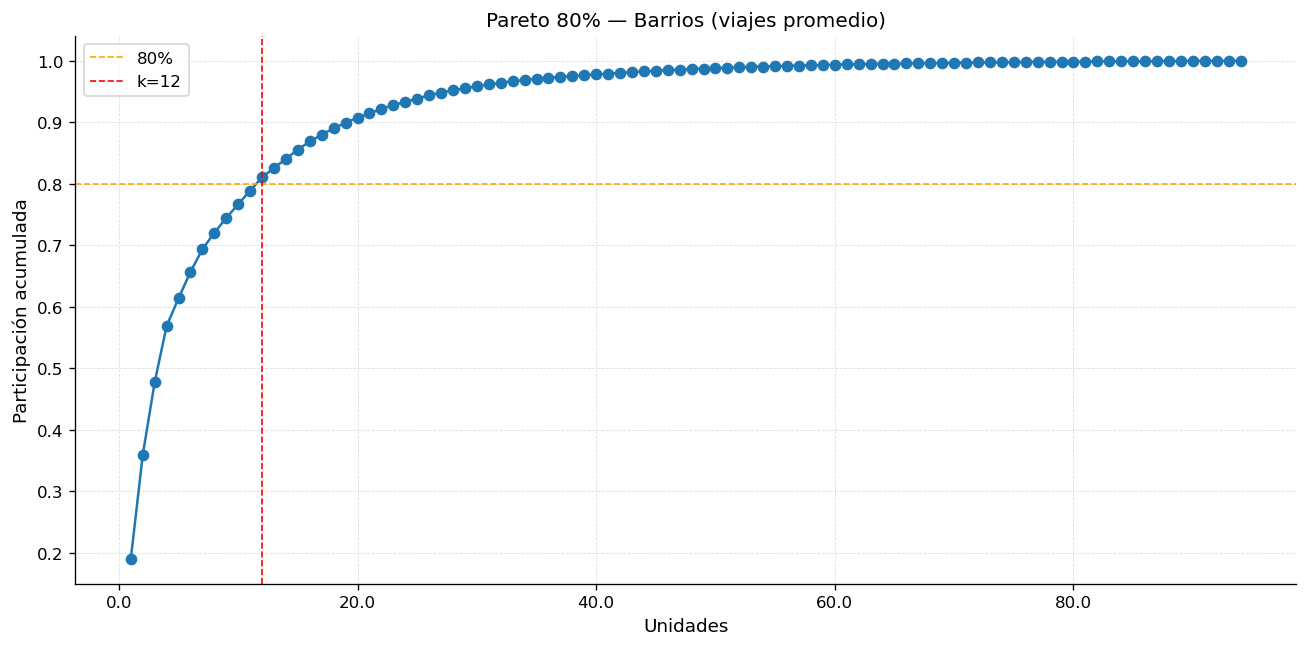

Pareto 80% — Barrios (viajes promedio) → k80=12, HHI=0.0966, CR4=0.569, CR8=0.720


In [7]:
# --- Análisis de concentración: Pareto + índices ---
def pareto_con_metricas(df_vals: pd.DataFrame,
                        col_val: str,
                        col_label: str,
                        titulo: str,
                        out_png: str | None = None) -> dict:
    """
    Calcula métricas de concentración (Pareto k80, HHI, CR4, CR8)
    y genera gráfico de curva de Pareto con línea 80%.

    Parámetros
    ----------
    df_vals : pd.DataFrame
        Dataset con al menos columnas [col_label, col_val].
    col_val : str
        Nombre de la columna de valores (ej. 'trips_amount').
    col_label : str
        Nombre de la columna de etiquetas (ej. 'company_name').
    titulo : str
        Título del gráfico y del print final.
    out_png : str | None
        Ruta para guardar el gráfico en PNG; si None, solo se muestra.

    Retorna
    -------
    dict
        Diccionario con:
        - 'k80': int, unidades necesarias para llegar al 80%.
        - 'HHI': float, índice de Herfindahl–Hirschman (0–1).
        - 'CR4': float, concentración de las 4 primeras unidades.
        - 'CR8': float, concentración de las 8 primeras unidades.
        - 'png': str | None, ruta del archivo si se guardó.
    """
    # 1) Ordenar valores descendentes
    s = df_vals[[col_label, col_val]].sort_values(col_val, ascending=False).reset_index(drop=True)

    total = float(s[col_val].sum())
    if total <= 0:
        raise ValueError(f"Total no válido (= {total}) en {col_val}.")

    # 2) Shares individuales y acumulados
    s['share'] = s[col_val] / total
    s['cum_share'] = s['share'].cumsum()

    # 3) k80: número mínimo de unidades para alcanzar 80%
    k80 = int((s['cum_share'] < 0.80).sum()) + 1

    # 4) Índices de concentración
    hhi = float((s['share']**2).sum())       # Herfindahl–Hirschman
    cr4 = float(s[col_val].nlargest(4).sum() / total)
    cr8 = float(s[col_val].nlargest(8).sum() / total)

    # 5) Gráfico de Pareto
    fig, ax = plt.subplots()
    ax.plot(range(1, len(s)+1), s['cum_share'], marker='o')
    ax.axhline(0.80, ls='--', lw=1, label='80%', color='orange')
    ax.axvline(k80, ls='--', lw=1, label=f'k={k80}', color='red')
    ax.set_xlabel("Unidades")
    ax.set_ylabel("Participación acumulada")
    ax.set_title(titulo)
    ax.xaxis.set_major_formatter(FuncFormatter(fmt_miles_inter))
    ax.grid(True, ls='--', alpha=0.4)
    ax.legend()
    fig.tight_layout()
    plt.show(); plt.close(fig)

    # 6) Reporte en consola
    print(f"{titulo} → k80={k80}, HHI={hhi:.4f}, CR4={cr4:.3f}, CR8={cr8:.3f}")

    return {'k80': k80, 'HHI': hhi, 'CR4': cr4, 'CR8': cr8, 'png': out_png}


# --- Ejecutar análisis de Pareto ---
m_emp = pareto_con_metricas(emp_ok, 'trips_amount', 'company_name',
                            "Pareto 80% — Empresas (viajes totales)", None)
m_bar = pareto_con_metricas(bar_ok, 'average_trips', 'dropoff_location_name',
                            "Pareto 80% — Barrios (viajes promedio)", None)


## 7. Conclusiones de concentración (HHI, CR4/CR8, k80)

### **Objetivo**
Resumir la **estructura de concentración** para empresas y barrios con métricas estándar y una lectura ejecutiva accionable.

### **Qué hace este bloque y por qué**
- Calcula **HHI**, **CR4**, **CR8** y **k(80%)**, y entrega una **interpretación cualitativa** (baja/moderada/alta) basada en HHI.  
- Integra una **lectura cruzada** tipo *long tail vs. concentración* para priorizar acciones (partnering, cobertura, monitoreo).  
- Devuelve las conclusiones en **Markdown**, listo para reportes y repositorio del sprint.

### **Resultados esperados**
- Entendimiento claro de si el mercado depende de **pocos actores** o de una **cola larga** de participantes.  
- Recomendaciones concretas para **negociación**, **foco geográfico** y **seguimiento periódico**.


In [8]:
# --- Métricas de concentración: soporte ---
def _compute_metrics_from_df(df: pd.DataFrame, col_val: str) -> dict | None:
    """
    Calcula métricas de concentración a partir de una columna numérica.

    Métricas:
      - HHI  (0–1): Índice Herfindahl–Hirschman (suma de cuadrados de shares).
      - CR4  (0–1): Participación acumulada del Top 4.
      - CR8  (0–1): Participación acumulada del Top 8.
      - k80  (int): Nº mínimo de unidades para alcanzar 80% (regla de Pareto).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    col_val : str
        Columna con los valores (debe ser numérica y >0 para entrar al cálculo).

    Retorna
    -------
    dict | None
        Diccionario con métricas o None si no hay datos válidos.
    """
    # Serie numérica positiva
    s = pd.to_numeric(df[col_val], errors='coerce').dropna().astype(float)
    s = s[s > 0]
    if s.empty:
        return None

    total = float(s.sum())
    if total <= 0:
        return None

    # Shares e índices
    share = s / total
    hhi = float((share ** 2).sum())
    cr4 = float(s.nlargest(4).sum() / total)
    cr8 = float(s.nlargest(8).sum() / total)

    # k80: mínimo k para acumular 80%
    srt = s.sort_values(ascending=False).reset_index(drop=True)
    k80 = int(((srt / total).cumsum() < 0.80).sum()) + 1

    return {"HHI": hhi, "CR4": cr4, "CR8": cr8, "k80": k80}


def _classify_hhi(hhi: float) -> str:
    """
    Clasifica la concentración según HHI (escala 0–1).

    < 0.15 → "baja (no concentrado)"
    [0.15, 0.25) → "moderada"
    ≥ 0.25 → "alta"
    """
    if hhi < 0.15:
        return "baja (no concentrado)"
    elif hhi < 0.25:
        return "moderada"
    else:
        return "alta"


# --- Conclusiones en Markdown ---
def generar_conclusiones(emp_ok: pd.DataFrame,
                         bar_ok: pd.DataFrame,
                         m_emp: dict | None = None,
                         m_bar: dict | None = None,
                         titulo: str = "Conclusiones:") -> str:
    """
    Genera un reporte conciso en Markdown sobre concentración de
    EMPRESAS (trips_amount) y BARRIOS (average_trips).

    Si se proveen métricas precomputadas (m_emp/m_bar), las usa;
    de lo contrario, las calcula desde los DataFrames limpios.

    Parámetros
    ----------
    emp_ok : pd.DataFrame
        Empresas, con columna 'trips_amount'.
    bar_ok : pd.DataFrame
        Barrios, con columna 'average_trips'.
    m_emp : dict | None
        Métricas precomputadas para empresas (HHI, CR4, CR8, k80).
    m_bar : dict | None
        Métricas precomputadas para barrios (HHI, CR4, CR8, k80).
    titulo : str
        Encabezado del bloque Markdown.

    Retorna
    -------
    str
        Texto en Markdown (también se renderiza con display si es posible).

    Lanza
    -----
    RuntimeError
        Si no hay métricas válidas para alguna de las dos vistas.
    """
    # 1) Obtener métricas (precalculadas o desde DF)
    met_emp = m_emp if isinstance(m_emp, dict) else _compute_metrics_from_df(emp_ok, "trips_amount")
    met_bar = m_bar if isinstance(m_bar, dict) else _compute_metrics_from_df(bar_ok, "average_trips")
    if met_emp is None or met_bar is None:
        raise RuntimeError("No hay métricas válidas para generar conclusiones.")

    # 2) Clasificación por HHI
    emp_hhi_class = _classify_hhi(met_emp["HHI"])
    bar_hhi_class = _classify_hhi(met_bar["HHI"])

    # 3) Texto guía (ayuda a lectores no técnicos)
    explicacion = (
        "- **HHI (Herfindahl–Hirschman)**: suma de cuadrados de participaciones; 0 = atomizado, 1 = monopolio. "
        "Umbrales (0–1): < 0.15 **baja**, 0.15–0.25 **moderada**, ≥ 0.25 **alta**.\n"
        "- **CR4/CR8**: fracción total del Top 4/8; más alto ⇒ mayor dependencia de pocos actores.\n"
        "- **k(80%)**: mínimo de unidades para superar 80%; k alto sugiere *long tail* más extensa.\n"
    )

    # 4) (Opcional) breve comparación cruzada para dar “lectura ejecutiva”
    foco_empresas = "long tail relevante" if met_emp["k80"] > 10 else "mercado más concentrado"
    foco_barrios  = "long tail relevante" if met_bar["k80"] > 10 else "mercado más concentrado"

    md = f"""
# {titulo}

**Empresas**  
- **HHI:** {met_emp['HHI']:.4f} → **{emp_hhi_class}**  
- **CR4 / CR8:** {met_emp['CR4']*100:.1f}% / {met_emp['CR8']*100:.1f}%  
- **80/20:** **k = {met_emp['k80']}** empresas para cubrir el **80%** → {foco_empresas}.

**Barrios** *(viajes promedio)*  
- **HHI:** {met_bar['HHI']:.4f} → **{bar_hhi_class}**  
- **CR4 / CR8:** {met_bar['CR4']*100:.1f}% / {met_bar['CR8']*100:.1f}%  
- **80/20:** **k = {met_bar['k80']}** barrios para cubrir el **80%** → {foco_barrios}.

**Implicaciones**  
1. **Partnering**: priorizar acuerdos con Top-8; mitigar riesgo si CR4/CR8 y HHI son elevados.  
2. **Cobertura geográfica**: asegurar presencia en barrios Top, diseñar pilotos para activar la *long tail*.  
3. **Monitoreo**: tablero mensual con **HHI/CRk/Pareto** para detectar cambios estructurales.

**Cómo leer los estadísticos**  
{explicacion}

*Nota:* HHI en escala **0–1** (no 0–10000). CRk en **% del total**.
""".strip()

    # 5) Render no bloqueante + retorno del string
    try:
        from IPython.display import Markdown, display  # seguro en notebook
        display(Markdown(md))
    except Exception:
        print(md)

    return md


# --- Ejecutar (usa emp_ok / bar_ok y, si existen, m_emp / m_bar) ---
try:
    _ = generar_conclusiones(emp_ok, bar_ok, m_emp=m_emp, m_bar=m_bar)
except Exception as e:
    print("⚠️ No se pudieron generar conclusiones:", e)

# Conclusiones:

**Empresas**  
- **HHI:** 0.0642 → **baja (no concentrado)**  
- **CR4 / CR8:** 37.3% / 62.5%  
- **80/20:** **k = 13** empresas para cubrir el **80%** → long tail relevante.

**Barrios** *(viajes promedio)*  
- **HHI:** 0.0966 → **baja (no concentrado)**  
- **CR4 / CR8:** 56.9% / 72.0%  
- **80/20:** **k = 12** barrios para cubrir el **80%** → long tail relevante.

**Implicaciones**  
1. **Partnering**: priorizar acuerdos con Top-8; mitigar riesgo si CR4/CR8 y HHI son elevados.  
2. **Cobertura geográfica**: asegurar presencia en barrios Top, diseñar pilotos para activar la *long tail*.  
3. **Monitoreo**: tablero mensual con **HHI/CRk/Pareto** para detectar cambios estructurales.

**Cómo leer los estadísticos**  
- **HHI (Herfindahl–Hirschman)**: suma de cuadrados de participaciones; 0 = atomizado, 1 = monopolio. Umbrales (0–1): < 0.15 **baja**, 0.15–0.25 **moderada**, ≥ 0.25 **alta**.
- **CR4/CR8**: fracción total del Top 4/8; más alto ⇒ mayor dependencia de pocos actores.
- **k(80%)**: mínimo de unidades para superar 80%; k alto sugiere *long tail* más extensa.


*Nota:* HHI en escala **0–1** (no 0–10000). CRk en **% del total**.